In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics,cluster 
from umap import UMAP
import multiscale_phate as mp

import scanpy as sc
import scprep

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
adata = sc.read_h5ad('Lake_2018.h5ad')
adata

AnnData object with n_obs × n_vars = 35289 × 43549
    obs: 'cell_type1', 'region', 'donor', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes'
    uns: 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'donor_colors', 'neighbors', 'region_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [3]:
data_group = adata.obs['cell_ontology_class']
n_groups = 9
set(data_group)

{'Purkinje cell',
 'astrocyte',
 'brain pericyte',
 'cerebellar granule cell',
 'endothelial cell',
 'microglial cell',
 'neuron',
 'oligodendrocyte',
 'oligodendrocyte precursor cell'}

C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


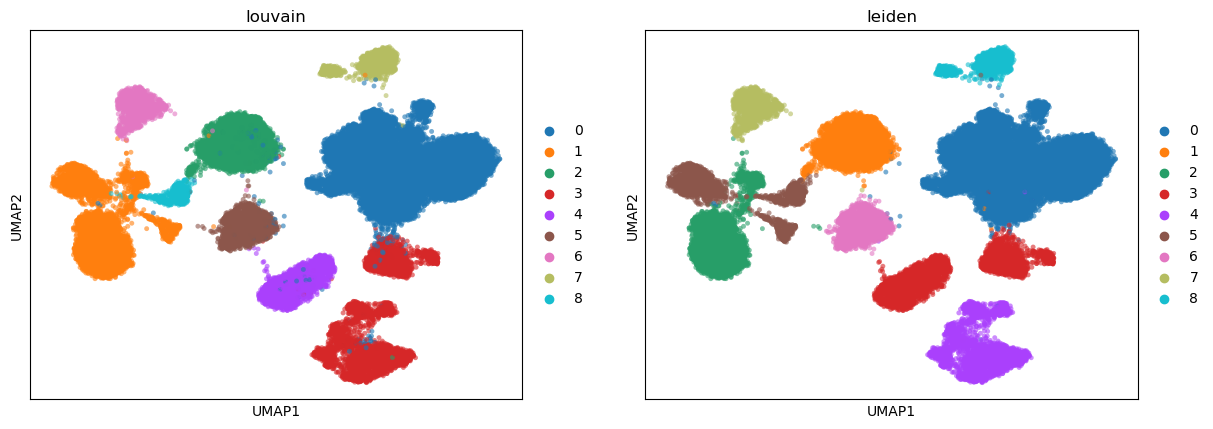

leiden: 0.5187989129769215 0.6671014405784337
louvain: 0.5106188898164706 0.6553437111727373


In [13]:
# sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.07, use_weights=True)
sc.tl.louvain(adata,resolution=0.07, use_weights=True)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=3)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, data_group)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, data_group)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, data_group)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, data_group)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

In [14]:
from dtne import *

In [4]:
X = adata.obsm['latent']

In [20]:
embedding = DTNE(k_neighbors = 10) 
Y = embedding.fit_transform(X)
dtne_cluster = embedding.cluster_cells(n_clusters=n_groups)

ari_dtne = metrics.adjusted_rand_score(dtne_cluster, data_group)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, data_group)
print("dtne:",ari_dtne,ami_dtne)

dtne: 0.5686635335929706 0.6945073883597733


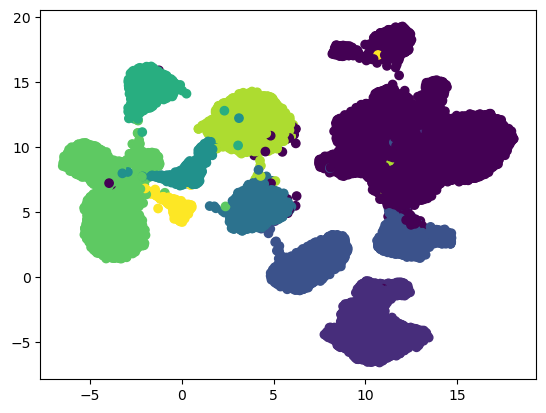

In [21]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster)

In [22]:
agglo_instance = cluster.AgglomerativeClustering(n_clusters=n_groups).fit(X)
agglo_groups = agglo_instance.labels_
ari_agglo = metrics.adjusted_rand_score(agglo_groups, data_group)
ami_agglo = metrics.adjusted_mutual_info_score(agglo_groups, data_group)

print("hierarchical:",ari_agglo,ami_agglo)

hierarchical: 0.3233768141816724 0.6048599777610769


In [5]:
X.shape

(35289, 10)

In [6]:
mp_op = mp.Multiscale_PHATE(random_state=0,n_pca=10,n_jobs=-2)
levels = mp_op.fit(X)
levels

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 25.23 seconds.
  Setting epsilon to 2.599
  Setting merge threshold to 0.6265
  Calculating condensation...
  Calculated condensation in 183.31 seconds.
Calculated Multiscale PHATE tree in 219.44 seconds.
Computing gradient...
Identifying salient levels of resolution...


[0, 11, 51, 64, 69, 90, 111, 117, 128, 143, 156]

In [14]:
tree_clusters = mp_op.get_tree_clusters(128)

In [23]:
len(set(tree_clusters))

12

In [20]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 128)

In [21]:
ari_mp = metrics.adjusted_rand_score(mp_clusters, data_group)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, data_group)
print("Multiscale PHATE:",ari_mp,ami_mp)

Multiscale PHATE: 0.47430187130126733 0.5716045204997071


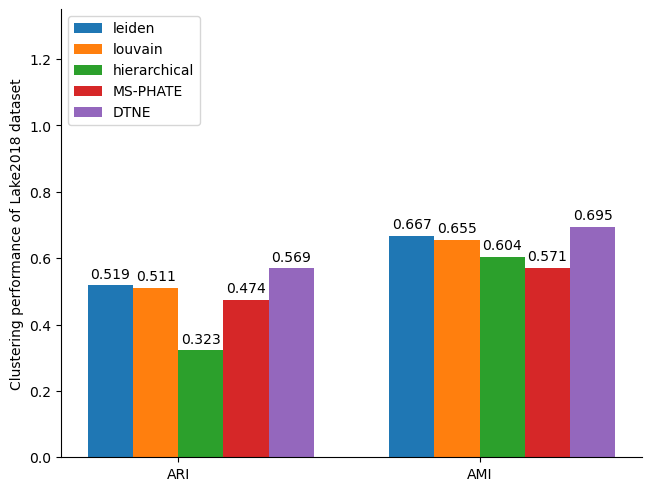

In [22]:
correlation = ['ARI','AMI']
pseudotime_corr = {
    'leiden':(0.519, 0.667),
    'louvain':(0.511, 0.655),
    'hierarchical':(0.323, 0.604),
    'MS-PHATE':(0.474, 0.571),
    'DTNE':(0.569, 0.695)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Clustering performance of Lake2018 dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig('./Lake2018_plot.png', format='png', dpi=1000)
plt.savefig('./Lake2018_plot.pdf', format='pdf', dpi=1000)